## El proyecto elegido es el de emparejamiento de rostros

### Librerías:

In [13]:
import cv2
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

### Extracción:

In [2]:
train_text = pd.read_csv("train.csv")
test_text = pd.read_csv("test.csv")
train_data = train_text["image1_image2"].to_numpy()
test_data = test_text["image1_image2"].to_numpy()
label_data = train_text["label"].to_numpy()
# diff = 0, same = 1
labels, clases = pd.factorize(label_data)

In [3]:
x_train = []
y_train = []
for i, imagenes_id in enumerate(train_data):
    par = imagenes_id.split('_')
    label = labels[i]
    imagen1 = cv2.imread('images/' + par[0] + '.png', cv2.IMREAD_GRAYSCALE)
    imagen2 = cv2.imread('images/' + par[1] + '.png', cv2.IMREAD_GRAYSCALE)
    imagenes = [imagen1, imagen2]
    imagenesinv = [imagen2, imagen1]
    m = [[]]
    m[0].append(label)
    input = torch.tensor(imagenes, dtype=torch.float32)
    inputinv = torch.tensor(imagenesinv, dtype=torch.float32)
    output_true = torch.tensor(m, dtype=torch.float32)
    x_train.append(input)
    x_train.append(inputinv)
    y_train.append(output_true)
    y_train.append(output_true)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.30, random_state=42)

C:\Users\jjosn\AppData\Local\Temp\ipykernel_11200\3205260307.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  input = torch.tensor(imagenes, dtype=torch.float32)


### Modelo:

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(in_features=16*33*33, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(-1, 16*33*33)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out
    
model = CNN()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Entrenamiento:

In [5]:
epochs = 10
for epoch in range(epochs):
    for id, imagenes in enumerate(x_train):
        output_true = y_train[id]
        optimizer.zero_grad()
        output = model(imagenes)
        loss = loss_fn(output, output_true)
        loss.backward()
        optimizer.step()
    print(f"epoch {epoch} loss: {loss.item()}")

torch.save(model, 'model.pth') 

epoch 0 loss: 0.7128029465675354
epoch 1 loss: 0.6906899213790894
epoch 2 loss: 0.6793791055679321
epoch 3 loss: 0.6679757833480835
epoch 4 loss: 0.6162598729133606
epoch 5 loss: 0.2489161193370819
epoch 6 loss: 0.1214832067489624
epoch 7 loss: 0.033192310482263565
epoch 8 loss: 0.01306077279150486
epoch 9 loss: 2.639191052367096e-07


In [15]:
model = torch.load("model.pth")
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=17424, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
)


### Validación:

In [16]:
y = []
for imagenes in x_val:
    output = model(imagenes)
    y.append(output)  
y = torch.tensor(y)
y_pred = y > 0
y_pred = y_pred.int()

y_val = torch.tensor(y_val)
y_val = y_val > 0
y_val = y_val.int()

C:\Users\jjosn\AppData\Local\Temp\ipykernel_11200\4172643183.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val = torch.tensor(y_val)


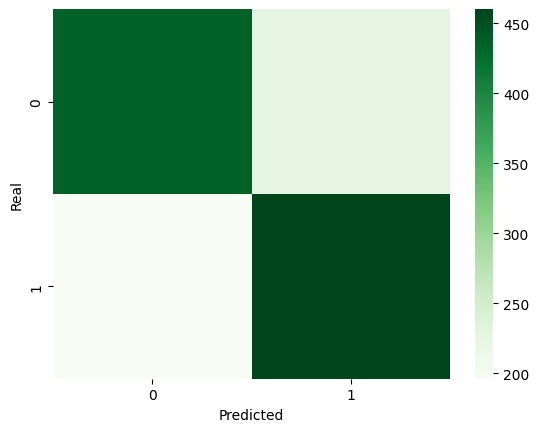

In [17]:
matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(matrix, cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.show()

In [18]:
print(f1_score(y_val, y_pred))
print(precision_score(y_val, y_pred))
print(recall_score(y_val, y_pred))
print(classification_report(y_val,y_pred))

0.6845238095238095
0.6686046511627907
0.7012195121951219
              precision    recall  f1-score   support

           0       0.69      0.66      0.67       664
           1       0.67      0.70      0.68       656

    accuracy                           0.68      1320
   macro avg       0.68      0.68      0.68      1320
weighted avg       0.68      0.68      0.68      1320



### Testing:

In [19]:
x_test = []
for imagenes_id in test_data:
    par = imagenes_id.split('_')
    imagen1 = cv2.imread('images/' + par[0] + '.png', cv2.IMREAD_GRAYSCALE)
    imagen2 = cv2.imread('images/' + par[1] + '.png', cv2.IMREAD_GRAYSCALE)
    imagenes = [imagen1, imagen2]
    input = torch.tensor(imagenes, dtype=torch.float32)
    x_test.append(input)

y_submit = []
for imagenes in x_test:
    output = model(imagenes)
    y_submit.append(output)  
y_submit = torch.tensor(y_submit)
y_submit = y_submit > 0
y_submit = y_submit.int()

In [20]:
y_submit = y_submit.numpy()
labe = []
for l in y_submit:
    if l == 0:
        labe.append("diff")
    else:
        labe.append("same")
submission = {"image1_image2": test_data, "label": labe}
submit = pd.DataFrame(submission)
submit.to_csv("submission.csv", index=False)